In [1]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, recall_score, RocCurveDisplay, PrecisionRecallDisplay, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

from exe_scanner import EXEScanner, MalwareDetectorWrapper
from malware_classifier import GBDTMalwareClassifier

# Setup EXE-scanner

## Load pretrained EXE-scanner

In [2]:
exe_scanner_model = GBDTMalwareClassifier("EXE_scanner_GBDT-dataset=benign-AE_all-before_2022", is_trained=True)

##################################################
Model loaded:
Name: EXE_scanner_GBDT-dataset=benign-AE_all-before_2022
Num trees: 1000
##################################################


## or Custom setup of EXE-scanner

In [3]:
# Load train set (see README for details on how to obtain the dataset)
X_train = pd.read_csv("data/X_train_benign-AE_all-before_2022.csv")
y_train = pd.read_csv("data/y_train_benign-AE_all-before_2022.csv")

In [4]:
# Train EXE-scanner
exe_scanner_model = GBDTMalwareClassifier("EXE_scanner_GBDT-dataset=benign-AE_all-before_2022", is_trained=False)
training_info = {}
exe_scanner_model.train(X_train, y_train["y"], training_info)
print(exe_scanner_model.name, "training info:", training_info)

/Users/matouskozk/miniconda3/envs/ae-detection-env/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 118994, number of negative: 100000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.093184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 218331
[LightGBM] [Info] Number of data points in the train set: 218994, number of used features: 2311
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543366 -> initscore=0.173903
[LightGBM] [Info] Start training from score 0.173903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

# Evaluation

In [5]:
# Load pretrained main classifier (see README for details on how to download pretrained models)
main_classifier_model = GBDTMalwareClassifier("CLF_GBDT-dataset=EMBER_train", is_trained=True)

##################################################
Model loaded:
Name: CLF_GBDT-dataset=EMBER_train
Num trees: 1000
##################################################


In [6]:
def finalize_predictions(y_true, y_pred, target_fpr, y_pred_second=None, verbose=False):
    if verbose:
        print("#" * 100)
        print("Dataset distribution:", np.unique(y_true, return_counts=True))
        print("Processing results...")
    
    fixed_predictions = {}

    fpr_arr, _, thresholds_roc = roc_curve(y_true, y_pred)
    
    threshold = thresholds_roc[fpr_arr < target_fpr][-1] # Get the threshold for the target FPR
        
    y_pred_binary = y_pred >= threshold

    standalone_pred_stats = np.unique(y_pred_binary, return_counts=True)
    if verbose:
        print("Y-true stats: ", np.unique(y_true, return_counts=True))
        print("Prediction standalone: ", standalone_pred_stats)
        print("Threshold standalone: ", threshold)
    
    # If the second model (EXE-scanner) is provided, combine the predictions
    if y_pred_second is not None:
        y_pred_combined = np.zeros_like(y_pred)

        # Replace the 0 prediction (benign) with the second model prediction score
        for i, pred in enumerate(y_pred_binary):
            if pred == False:
                y_pred_combined[i] = y_pred_second[i]
            else:
                y_pred_combined[i] = 1.0

        # Recalculate new thresholds
        fpr_arr_combined, _, thresholds_roc_combined = roc_curve(y_true, y_pred_combined)
        threshold_combined = thresholds_roc_combined[fpr_arr_combined < target_fpr][-1]
            
        combined_pred_stats = np.unique(y_pred_combined, return_counts=True)
        if verbose:
            print("Threshold combined: ", threshold_combined)
            print("Prediction combined: ", combined_pred_stats)

        # Update the binary prediction (leave the first model malicious=1 prediction)
        num_malicious = 0
        for i, pred in enumerate(y_pred_combined):
            if y_pred_binary[i] == 1:
                num_malicious += 1
                continue
            else:
                y_pred_binary[i] = y_pred_combined[i] >= threshold_combined

        # Same for this assert
        assert num_malicious == combined_pred_stats[1][-1], f"Malicious predictions should be transfered to combined model with EXE-scanner, {num_malicious} != {combined_pred_stats[1][-1]}"

    # Results for the binary prediction
    y_pred_binary = y_pred_binary.astype(int)
    fpr = np.sum(y_true[y_pred_binary == 1] == 0) / np.sum(y_true == 0)
    fnr = np.sum(y_true[y_pred_binary == 0] == 1) / np.sum(y_true == 1)

    fixed_predictions[target_fpr] = {
        "y_pred": y_pred_binary,
        "y_pred_combined": y_pred_combined if y_pred_second is not None else None,
        "threshold": threshold,
        "threshold_combined": threshold_combined if y_pred_second is not None else None,
    }

    if verbose:
        fig, [ax_roc, ax_ap] = plt.subplots(1, 2, figsize=(11, 5))
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax_ap, name="Main Classifier")
        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax_roc, name="Main Classifier")

        if y_pred_second is not None:
            PrecisionRecallDisplay.from_predictions(y_true, y_pred_second, ax=ax_ap, name="EXE-Scanner")
            RocCurveDisplay.from_predictions(y_true, y_pred_second, ax=ax_roc, name="EXE-Scanner")

            PrecisionRecallDisplay.from_predictions(y_true, y_pred_combined, ax=ax_ap, name="Combined Detector")
            RocCurveDisplay.from_predictions(y_true, y_pred_combined, ax=ax_roc, name="Combined Detector")

        ax_roc.grid(linestyle="--")
        ax_ap.grid(linestyle="--")
        
        # Zoom ax_ap to the top right corner
        ax_ap.set_xlim([0.8, 1.0])
        ax_ap.set_ylim([0.8, 1.0])

        # Zoom ax_roc to the top left corner
        ax_roc.set_xlim([0.0, 0.2])
        ax_roc.set_ylim([0.8, 1.0])

        # Move y-axis of ax_ap to the right
        ax_ap.yaxis.tick_right()
        ax_ap.yaxis.set_label_position("right")

        plt.show()

    return fixed_predictions


In [7]:
# Load test set (see README for details on how to obtain the dataset)
X_test = pd.read_csv("data/X_test_benign-AE_all-before_2022.csv")
y_test = pd.read_csv("data/y_test_benign-AE_all-before_2022.csv")

####################################################################################################
Dataset distribution: (array([0, 1]), array([24202, 16323]))
Processing results...
Y-true stats:  (array([0, 1]), array([24202, 16323]))
Prediction standalone:  (array([False,  True]), array([25406, 15119]))
Threshold standalone:  0.4413384963629881
Threshold combined:  0.9999999950656784
Prediction combined:  (array([1.54755413e-11, 2.39238896e-11, 2.71761080e-11, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), array([    1,     1,     1, ...,     1,     1, 15119]))


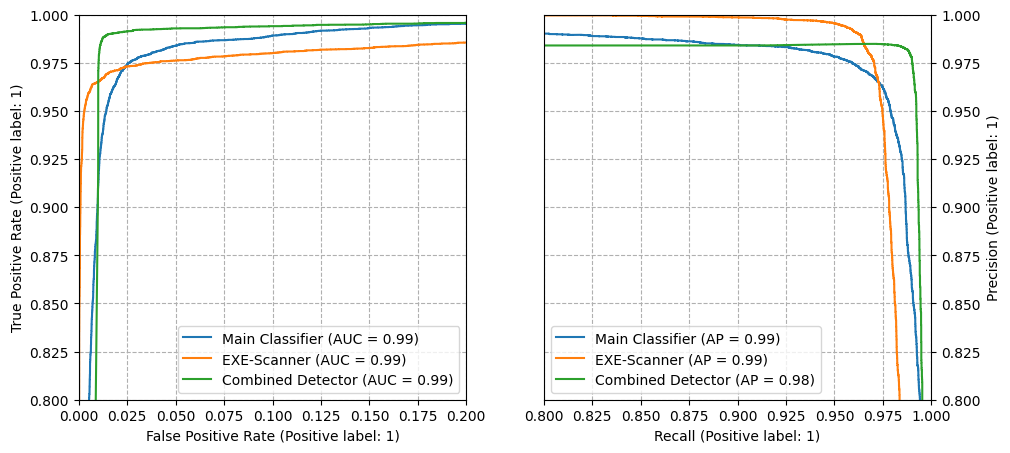

In [8]:
y_test_pred_main_clf = main_classifier_model.predict_proba(X_test)
y_test_pred_exe_scanner = exe_scanner_model.predict_proba(X_test)

fixed_predictions_standalone = finalize_predictions(y_test["y"], y_test_pred_main_clf, target_fpr=0.01, verbose=False)
fixed_predictions_combined = finalize_predictions(y_test["y"], y_test_pred_main_clf, target_fpr=0.01, y_pred_second=y_test_pred_exe_scanner, verbose=True)

### Compare acurracy, precision, recall and F1-score of the standalone and combined models

In [9]:
accuracy_standalone = accuracy_score(y_test["y"], fixed_predictions_standalone[0.01]["y_pred"])
precision_standalone = precision_score(y_test["y"], fixed_predictions_standalone[0.01]["y_pred"])
recall_standalone = recall_score(y_test["y"], fixed_predictions_standalone[0.01]["y_pred"])
f1_standalone = f1_score(y_test["y"], fixed_predictions_standalone[0.01]["y_pred"])

accuracy_combined = accuracy_score(y_test["y"], fixed_predictions_combined[0.01]["y_pred"])
precision_combined = precision_score(y_test["y"], fixed_predictions_combined[0.01]["y_pred"])
recall_combined = recall_score(y_test["y"], fixed_predictions_combined[0.01]["y_pred"])
f1_combined = f1_score(y_test["y"], fixed_predictions_combined[0.01]["y_pred"])

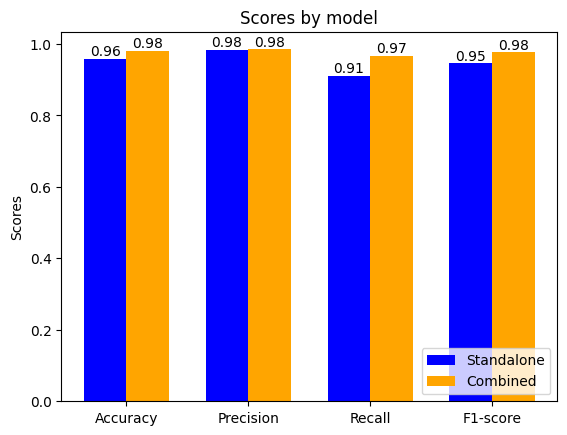

In [10]:
fig, ax = plt.subplots()
width = 0.35
x = np.arange(4)
labels = ["Accuracy", "Precision", "Recall", "F1-score"]
values_standalone = [accuracy_standalone, precision_standalone, recall_standalone, f1_standalone]
values_combined = [accuracy_combined, precision_combined, recall_combined, f1_combined]

rects1 = ax.bar(x - width/2, values_standalone, width, label='Standalone', color="blue")
rects2 = ax.bar(x + width/2, values_combined, width, label='Combined', color="orange")

ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

# Add values to the bars
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height,
            f'{height:.2f}', ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height,
            f'{height:.2f}', ha='center', va='bottom')

plt.show()

### Calculate bad churn (regressions in model accuracy)

In [11]:
def find_different_indices(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")
    
    different_indices = [i for i in range(len(array1)) if array1[i] != array2[i]]
    return different_indices

# Calculates "bad churn" - when the new model makes a mistake that the old model did not make
def calculate_bad_churn(y_true, y_pred_standalone, y_pred_combined, verbose=False):
    # Verify inputs
    if len(y_true) != len(y_pred_standalone) or len(y_true) != len(y_pred_combined):
        raise ValueError("Input arrays must have the same length")

    if verbose:
        print(f"y_true: {y_true}")
        print(f"y_pred_standalone: {y_pred_standalone}")
        print(f"y_pred_combined: {y_pred_combined}")

    # Calculate totals
    total_benign = total_malicious = 0
    for y in y_true:
        if y == 0:
            total_benign += 1
        else:
            total_malicious += 1

    if verbose:
        print(f"Total benign: {total_benign}")
        print(f"Total malicious: {total_malicious}")

    # Calculate indices where the combined model made a mistake
    incorrect_standalone = find_different_indices(y_true, y_pred_standalone)
    incorrect_combined = find_different_indices(y_true, y_pred_combined)

    if verbose:
        print(f"Incorrect standalone: {y_true != y_pred_combined}")
        print(f"Incorrect combined: {y_true != y_pred_standalone}")
        print(f"Incorrect standalone indices: {incorrect_standalone}")
        print(f"Incorrect combined indices: {incorrect_combined}")

    # Calculate bad churn, where the new model made a mistake that the standalone model did not
    bad_churn_benign = bad_churn_malicious = 0
    for idx in incorrect_combined:
        if idx not in incorrect_standalone:
            if y_true[idx] == 0:
                bad_churn_benign += 1
            else:
                bad_churn_malicious += 1


    results = {
        "benign_churn_rate": bad_churn_benign / total_benign,
        "malicious_churn_rate": bad_churn_malicious / total_malicious,
        "benign_churn": bad_churn_benign,
        "malicious_churn": bad_churn_malicious,
    }

    if verbose:
        print(f"Bad churn benign: {bad_churn_benign}/{total_benign}")
        print(f"Bad churn malicious: {bad_churn_malicious}/{total_malicious}")

    return results

In [12]:
bad_churn_results = calculate_bad_churn(y_test["y"], fixed_predictions_standalone[0.01]["y_pred"], fixed_predictions_combined[0.01]["y_pred"], verbose=False)

print(f"Goodware Flip Rate: {bad_churn_results['benign_churn_rate']:.2f}")
print(f"Malware Flip Rate: {bad_churn_results['malicious_churn_rate']:.2f}")
print(f"Num. Goodware Flips: {bad_churn_results['benign_churn']}")
print(f"Num. Malware Flips: {bad_churn_results['malicious_churn']}")

Goodware Flip Rate: 0.00
Malware Flip Rate: 0.00
Num. Goodware Flips: 0
Num. Malware Flips: 0


# Real-world executable files

In [13]:
class WrapperEXEscanner:
    """
    A wrapper class for the use of EXE scanner with standalone malware classifier.

    Parameters:
    - main_classifier: The main classifier model.
    - EXE_scanner: The EXE scanner model.
    - main_classifier_threshold: The threshold value for the main classifier. (optional)

    Methods:
    - predict_sample(bytez, return_score=False): Predicts the label for a given sample.

    """

    def __init__(self, main_classifier, EXE_scanner):
        self.main_classifier = main_classifier
        self.EXE_scanner = EXE_scanner

    def predict_sample(self, bytez, return_score=False):
        """
        Predicts the label for a given sample.

        Parameters:
        - bytez: The input sample in byte format.
        - return_score: Whether to return the prediction score. (default: False)

        Returns:
        - predicted_label: The predicted label for the sample.
        - score: The prediction score (if return_score is True).

        """

        score = self.main_classifier.get_score(bytez)
        is_malicious = score > self.main_classifier.threshold
        print(f"Main classifier prediction: {is_malicious} with score {score}")
        if not is_malicious:
            score = self.EXE_scanner.get_score(bytez)
            is_malicious = score > self.EXE_scanner.threshold
            print(f"EXE scanner prediction: {is_malicious} with score {score}")

        predicted_label = int(is_malicious)
        if return_score:
            return predicted_label, score
        else:
            return predicted_label

In [14]:
main_classifier_model = GBDTMalwareClassifier("CLF_GBDT-dataset=EMBER_train", is_trained=True)
main_classifier = MalwareDetectorWrapper(main_classifier_model, threshold=0.4413384963629881) # Threshold saved in "data/models/fixed_thresholds/CLF_GBDT-dataset=EMBER_train-test_dataset=before2022/..."
exe_scanner = EXEScanner(target_fpr=0.01)
exe_scanner_pipeline = WrapperEXEscanner(main_classifier, exe_scanner)

##################################################
Model loaded:
Name: CLF_GBDT-dataset=EMBER_train
Num trees: 1000
##################################################
##################################################
Model loaded:
Name: EXE_scanner_GBDT-dataset=benign-AE_all-before_2022
Num trees: 1000
##################################################


In [15]:
# Requires placing executables inside "samples" folder in the root of this repository
SAMPLE_FOLDER = "samples"
for file in os.listdir(SAMPLE_FOLDER):
    with open(os.path.join(SAMPLE_FOLDER, file), "rb") as f:
        bytez = f.read()
        label, score = exe_scanner_pipeline.predict_sample(bytez, return_score=True)
        print(f"{file}: {label} ({score})")

Main classifier prediction: False with score 0.00192148027492247
EXE scanner prediction: False with score 0.7716771419831085
HelloWorld: 0 (0.7716771419831085)
